# ALIGNED project: Comparative Monte Carlo

**Aligning Life Cycle Assessment methods and bio-based sectors for improved environmental performance**

[http://www.alignedproject.eu/](http://www.alignedproject.eu/)

_Horizon Europe grant agreement N° 101059430. Views and opinions expressed are however those of the author(s) only and do not necessarily reflect those of the European Union or the European Research Executive Agency._ 


## WP1 Shared modelling framework and learnings
### Task 1.4 Framework for interpreting uncertainty

#### Deliverable 1.2 Description of scientific methods

#### Tutorial for performing a comparative Monte Carlo uncertainty analysis

#### Massimo Pizzol, Aalborg University (AAU), 2024

This notebook shows how to perform an uncertainty analysis on an example product system of a biobased product. 

In particular here a comparative Monte Carlo is performed, the type of simulation to be used in comparative LCAs, i.e. in analyses where different alternatives to provide the same Functional Unit are compared. In this comparative case it is important to randomly sample a common technology matrix **A** for all alternatives at each iteration, instead of having a different technology matrix per each alternative at each iteration. This allows for a smaller variance and shorter computational times. Moreover, this allows not only to quantify the uncertainty of each alternative, but also to optimally perform the  statistical testing of the results with paired tests, to see if the two alternatives are significantly different from each other or not. 

A recommend supporting reading is Henriksson et al. (2015), probably the best example of an LCA with comparative Monte Carlo simulation followed by statistical testing for significant differences between alternatives. An application of this approach is also provided in Pizzol (2019).

_Henriksson, P. J. G., Rico, A., Zhang, W., Ahmad-Al-Nahid, S., Newton, R., Phan, L. T., … Guinée, J. B. (2015). Comparison of Asian Aquaculture Products by Use of Statistically Supported Life Cycle Assessment. Environmental Science and Technology, 49(24), 14176-14183._ [https://doi.org/10.1021/acs.est.5b04634](https://doi.org/10.1021/acs.est.5b04634)

_Pizzol, M., 2019. Deterministic and stochastic carbon footprint of intermodal ferry and truck freight transport across Scandinavian routes. Journal of Cleaner Production 224, 626–636._ https://doi.org/10.1016/j.jclepro.2019.03.270


In [1]:
# import packages
import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from lci_to_bw2 import * # import all the functions of this module

In [2]:
# open a project with ecoinvent v.3.11 consequential system model
bd.projects.set_current('advlca25')

We start by importing data about a fictional ("dummy") product system for a biobased product.

In [3]:
# Import the dummy product system

# import data from csv
mydata = pd.read_csv('ALIGNED-LCI-biobased-product-dummy.csv', header = 0, sep = ",") # using csv file avoids encoding problem
mydata.head()

# keep only the columns not needed
mydb = mydata[['Activity database','Activity code','Activity name','Activity unit','Activity type',
               'Exchange database','Exchange input','Exchange amount','Exchange unit','Exchange type',
               'Exchange uncertainty type','Exchange loc','Exchange scale','Exchange negative', 
               'Simapro name',	'Simapro unit', 'Simapro type']].copy()

mydb = mydata.copy()

mydb['Exchange uncertainty type'] = mydb['Exchange uncertainty type'].fillna(0).astype(int) # uncertainty as integers
# Note: to avoid having both nan and values in the uncertainty column I use zero as default

# Create dictionary in bw format and write database to disk. 
# Shut down all other notebooks using the same project before doing this
bw2_db = lci_to_bw2(mydb) # a function from the lci_to_bw2 module

# write database
bd.Database('ALIGNED-biob-prod-dummy').write(bw2_db)

08:07:49 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<00:00, 1012.14it/s]

08:07:49 [info     ] Vacuuming database            


The product system includes different activities such as the production, use, and end of life of the biobased product.

In [4]:
# check what foreground activities are included
for act in bd.Database('ALIGNED-biob-prod-dummy'):
    print(act, act['code'])

'Biobased-product-manufacturing' (kilogram, None, None) a37d149a-6508-4563-8af6-e5a39b4176df
'Biobased-product-use' (year, None, None) f9eabf64-b899-40c0-9f9f-2009dbb0a0b2
'Biomass-processing' (kilogram, None, None) 403a5c32-c769-46fc-8b9a-74b8eb3c79d1
'Biobased-product-eol' (kilogram, None, None) c8301e73-d521-4a89-998b-30b7e7751011
'Biomass-growth' (kilogram, None, None) a7d34649-9c10-4423-bac3-ecab9b43b20c


We calculate a static climate impact score for the fictional biobased product, to be used for reference later on.

In [5]:
# calculation of static LCA score
mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
use = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {use: 1}
LCA = bc.LCA(functional_unit, mymethod)
LCA.lci()
LCA.lcia()
print(LCA.score)

180.28497357367456


### A simple Stochastic simulation

We perform a simulation and calculate 100 results for the same functional unit using stochastic error propagation starting from the uncertainty in the foreground and background input data.

In [6]:
mc = bc.LCA(functional_unit, mymethod, use_distributions=True)
mc.lci()
mc.lcia()
mc_results = [mc.score for _ in zip(range(100), mc)] # will take a minute, we are randomly sampling ecoinvent 100 times

We then calculate descriptive statistics for the resulting distribution.

,0
count,100.000000
mean,211.823276
std,84.985016
min,101.620802
25%,162.323370
50%,197.319699
75%,234.759484
max,749.189491


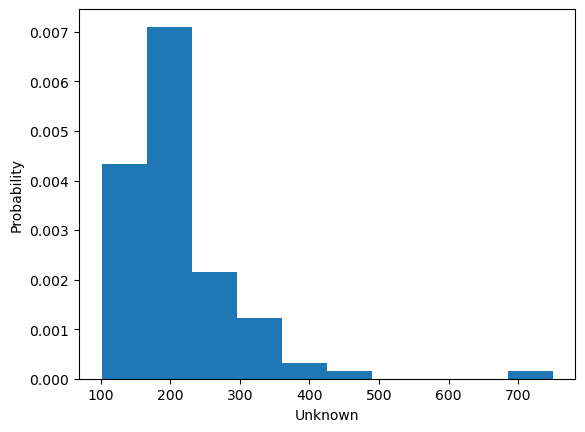

In [7]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bd.methods[mymethod]["unit"])
pd.DataFrame(mc_results).describe() 

### A comparative stochastic simulation

Now we perform stochastic simulation where we compare the initial product with a fictional alternative. Scores are calculated in a paired fashion so first (i) a new technology matrix is sampled, then (ii) results are calculated for each product using this matrix, and only then the procedure is iterated. In this way we ensure comparisons made on the same conditions at each iteration.

We first need to define the alternative product, this is a product where a larger amount of product items is needed in the use stage. The uncertainty estimates for this alternative products are also different.

In [8]:
if 'ALIGNED-biob-prod-dummy-alt' in bd.databases:
    del bd.databases['ALIGNED-biob-prod-dummy-alt']

In [9]:
# create a copy of the foreground database
db_alt = bd.Database('ALIGNED-biob-prod-dummy').copy('ALIGNED-biob-prod-dummy-alt')

08:10:23 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<00:00, 1347.96it/s]

08:10:23 [info     ] Vacuuming database            


In [10]:
# Now I modified this database to show that more product is used in the use stage.
use_alt = db_alt.get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2')
exc_alt = list(use_alt.exchanges())[1] # select the second exchange in the activity, i.e. the input from manufacturing
print('original: ', exc_alt) # checking the original

exc_alt['amount'] = 60 # I am increasing the amount of product needed in manufacturing
exc_alt['minimum'] = 60*0.8 # Some uncertainty, lower bound of uniform distribution
exc_alt['maximum'] = 60*1.2 # Some uncertainty, upper bound of uniform distribution
exc_alt.save() # important or the changes won't be maintained
print('alternative: ', exc_alt) # checking the  alternative

original:  Exchange: 50.0 kilogram 'Biobased-product-manufacturing' (kilogram, None, None) to 'Biobased-product-use' (year, None, None)>
alternative:  Exchange: 60 kilogram 'Biobased-product-manufacturing' (kilogram, None, None) to 'Biobased-product-use' (year, None, None)>


We can see that the uncertainty range is different for the two products.

In [11]:
# check that both amount and uncertainty values are different
print(list(use.exchanges())[1]._data, "\n---\n", list(use_alt.exchanges())[1]._data)

{'input': ('ALIGNED-biob-prod-dummy', 'a37d149a-6508-4563-8af6-e5a39b4176df'), 'amount': 50.0, 'unit': 'kilogram', 'type': 'technosphere', 'uncertainty type': 4, 'minimum': 37.5, 'maximum': 62.5, 'Notes': 'Input of manufacturing', 'Simapro name': 'Biobased-product-manufacturing', 'Simapro unit': 'kg', 'output': ('ALIGNED-biob-prod-dummy', 'f9eabf64-b899-40c0-9f9f-2009dbb0a0b2')} 
---
 {'input': ('ALIGNED-biob-prod-dummy-alt', 'a37d149a-6508-4563-8af6-e5a39b4176df'), 'amount': 60, 'unit': 'kilogram', 'type': 'technosphere', 'uncertainty type': 4, 'minimum': 48.0, 'maximum': 72.0, 'Notes': 'Input of manufacturing', 'Simapro name': 'Biobased-product-manufacturing', 'Simapro unit': 'kg', 'output': ('ALIGNED-biob-prod-dummy-alt', 'f9eabf64-b899-40c0-9f9f-2009dbb0a0b2')}


And the static impact score is also different

In [12]:
# check the static value is different
lca = bc.LCA({use_alt: 1}, mymethod)
lca.lci()
lca.lcia()
lca.score # higher impact as expected

206.1500978535176

Now I merge based product and its alternative in the same technology matrix and proceed with the stochastic comparative anlysis

In [13]:
# Create a database with both activities to have a common technology matrix.

cmc_db = bd.Database('cmc') # cmc = comparative Monte Carlo

# A simplified db, one foreground activity: 'Electricity production,
cmc_db.write({  
    ('cmc', 'cmc-act'): {
        'name': 'comparative monte carlo activity',
        'unit': 'p',
        'exchanges': [{
            'input': ('ALIGNED-biob-prod-dummy', 'f9eabf64-b899-40c0-9f9f-2009dbb0a0b2'), # first alternative
            'amount': 1,
            'type': 'technosphere'},
        {
            'input': ('ALIGNED-biob-prod-dummy-alt', 'f9eabf64-b899-40c0-9f9f-2009dbb0a0b2'), # second alternative
            'amount': 1,
            'type': 'technosphere'},
        {
            'input': ('cmc', 'cmc-act'),
            'amount': 1,
            'type': 'production'}]}})

# select the foreground activity and calculate result
#lca = bc.LCA({cmc_db.get('cmc-act'): 1}, mymethod)
#lca.lci()
#lca.lcia()

08:10:39 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]

08:10:39 [info     ] Vacuuming database            


In [14]:
# Initialize monte carlo simulation
mc = bc.LCA({cmc_db.get('cmc-act'): 1}, mymethod, use_distributions=True) # We are calculating the impact of transport with the use first
mc.lci()
mc.lcia()
mc.score

328.109206460778

#### (Technical note) 

The steps above were necessary as in this case as we start with importing a single product system. To analyise an alternative product we need first to create a copy of the existing database, modify it to add the alternative activity, and then obtain a common technology matrix. 

All this can be skipped if the alternatives to be compared are two distinct activities in the same foreground database and prepared originally in the data template and imported together.

#### Now finally comparative stochastic simulation

In [15]:
# a list ot he alternative to be compared
act_1 = bd.Database("ALIGNED-biob-prod-dummy").get("f9eabf64-b899-40c0-9f9f-2009dbb0a0b2").id
act_2 = bd.Database("ALIGNED-biob-prod-dummy-alt").get("f9eabf64-b899-40c0-9f9f-2009dbb0a0b2").id

demands = [{act_1:1}, {act_2:1}] # the alternative!

In [16]:
# look at this first
mc.redo_lcia(demands[0]) # use
print(mc.score)
mc.redo_lcia(demands[1]) # alternative use. I am using the same technology matrix "A" as before to calcualte results
print(mc.score)
mc.redo_lcia(demands[0]) # use again. Same result. Note how "redo.lcia" allows doing dependent sampling
print(mc.score)

193.28835525233137
134.82085120844627
193.28835525233137


In [17]:
# Now for several iterations
iterations = 100
simulations = [] # empty list that will contain the restuls of all iterations, for all alternatives

for _ in range(iterations):
    #print(_)
    next(mc)
    mcresults = []    # empty list that will contain results for one iteration, for two alteratives
    for i in demands:
        mc.redo_lcia(i)
        mcresults.append(mc.score)
    simulations.append(mcresults) # appends one list to another


What is obtained is two different distributions, one for the base product and one for the alternative. Each sample (iteration, or row in the table below) is paired.

In [18]:
# let's give a look
df = pd.DataFrame(simulations, columns = ['use','use_alt']) # df is for "dataframe"
#df.to_csv('ComparativeMCsimulation.csv') # to save it
df

,use,use_alt
0,269.398082,367.956255
1,172.761795,168.793544
2,177.092965,272.481372
3,215.576429,279.690723
4,159.082568,142.131691
...,...,...
95,243.362884,182.440032
96,124.192941,158.847413
97,446.399791,499.459434
98,223.455672,442.957774


A summary of these distributions shows that the median (50% percentile) impact score of the alternative (_use-alt_) is higher than the one of the original activity (_use_).

The summary also quantified the uncertainy as standard deviation (_sd_), which is large in this case (about half the value of the median).

In [19]:
df.describe()

,use,use_alt
count,100.000000,100.000000
mean,227.773669,257.578321
std,95.970091,126.033726
min,100.925252,112.928264
25%,155.745986,169.755286
50%,206.640023,222.922072
75%,269.593681,291.852923
max,475.066391,899.072150


This is also confirmed by a visual inspection. The distribution of the alternative (_use_alt_) is shifted upwards compared to the original (_use_). Also, there seems to be a linear relation between the two which confirms the paired sampling.

<Axes: >

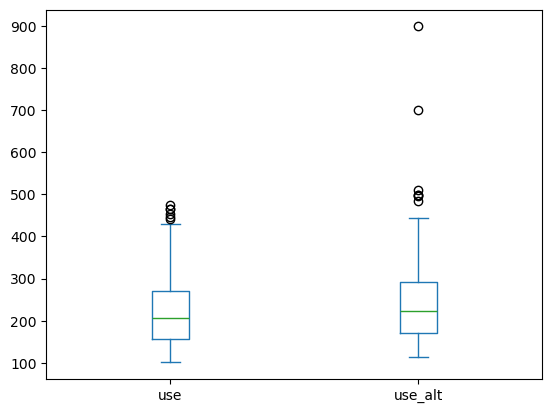

In [20]:
df.plot(kind = 'box')
#df.T.melt()

Plotting the results shows a hint of a trend, as expectable as results are paired so each point "depends" on the same background conditions.

Text(0, 0.5, 'use_alt - kg CO2-eq')

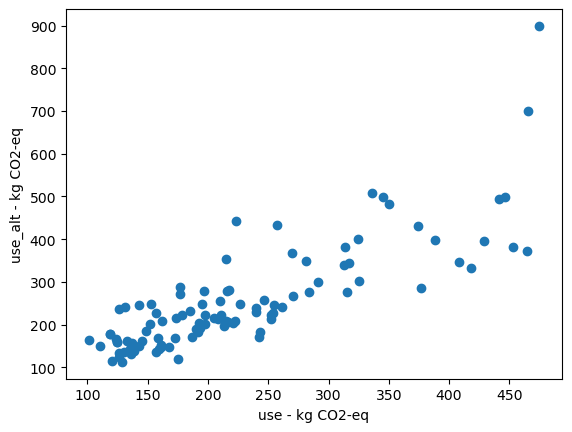

In [21]:
# plot one against the other to see if there is any trend
plt.plot(df['use'], df['use_alt'], 'o')
plt.xlabel('use - kg CO2-eq')
plt.ylabel('use_alt - kg CO2-eq')

### Testing for differences

This type of simulation allows to calculate differences and ratios between paired results. This allows to tell how many times one product had a better perfomance than the other across the entire simulation, and how large was this difference. 

These indicators can help to understand whether the differences observed are sufficiently large, in the light of the uncertainties, to conclude confidently that one product is better than the other, all remaining conditions being equal.

In [22]:
# You can see how many times the difference is positive. This is what SimaPro also does
df['diffe'] = df['use'] - df['use_alt']

# Ratio of the difference on each alternative respectively
df['rd_use'] = df['diffe']  / df['use']
df['rd_use_alt'] = df['diffe']  / df['use_alt']

df.describe()

,use,use_alt,diffe,rd_use,rd_use_alt
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,227.773669,257.578321,-29.804651,-0.148418,-0.081116
std,95.970091,126.033726,73.111387,0.283160,0.204884
min,100.925252,112.928264,-424.005759,-0.982307,-0.495537
25%,155.745986,169.755286,-56.777537,-0.289497,-0.224494
50%,206.640023,222.922072,-11.193345,-0.057772,-0.054616
75%,269.593681,291.852923,10.156746,0.051287,0.054060
max,475.066391,899.072150,91.614896,0.314976,0.459804


In this specific case one can see that out of 100 times the alternative is worse than the based case in two thirds (63%) of cases. And the differences are distributed a bit on the left of the zero. The intepretation is that one can not conclude that the original activity is always outperforming the alternative, given the uncertainties, but the original is often the better option. It is up to the decision maker to set a threshold of performance to make a decision (is 66% sufficient to decide to keep the original and discard the alternative?). 

60
40
0


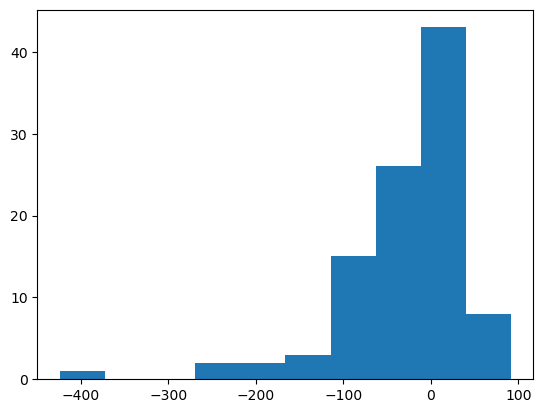

In [23]:
# Let's plot and count the differences.
plt.hist(df.diffe.values)
print(len(df.diffe[df.diffe < 0]))
print(len(df.diffe[df.diffe > 0]))
print(len(df.diffe[df.diffe == 0]))

Plotting the ratios shows that the size of differences between alternatives can be very substantial, where the alternative can have an impact that is double than the original, and viceversa (both positive and negative ratios are present). Also, the way ratios are calculated does not influence this conclusion. 

(array([ 6., 11., 12., 11., 20., 18., 13.,  5.,  2.,  2.]),
 array([-0.49553731, -0.40000321, -0.30446911, -0.20893501, -0.11340091,
        -0.01786682,  0.07766728,  0.17320138,  0.26873548,  0.36426957,
         0.45980367]),
 <BarContainer object of 10 artists>)

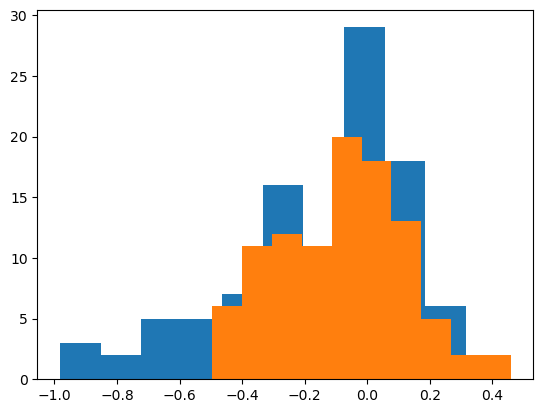

In [24]:
plt.hist(df['rd_use'].values)
plt.hist(df['rd_use_alt'].values)

Finally, the paired sampling approach allows to perform a more formal statistical testing such as a paired t-test. This is in order to understand if the difference observed are significant given the underlying uncertainties.

In [25]:
# Statistical testing (using the stats package)
# I can use a paired t-test

t_value, p_value = stats.ttest_rel(df['use'],df['use_alt'])
t_value, p_value # very low value

(-4.076608665051498, 9.238648766257714e-05)

8.112548569576278e-07
1.0504874989743626e-09


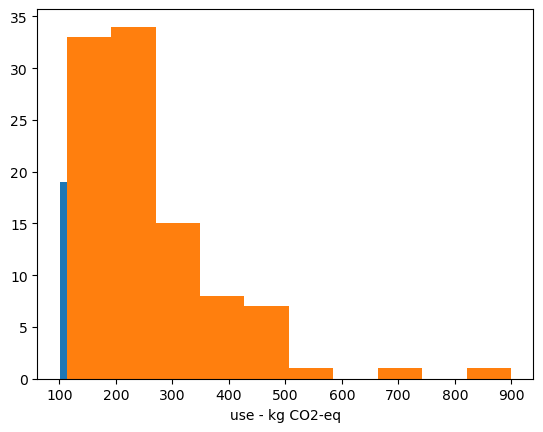

In [26]:
# Checking for normality
plt.hist(df['use'].values)
plt.xlabel('use - kg CO2-eq')

SW_value, SW_p_value = stats.shapiro(df['use'])
print(SW_p_value) # Not normally distributed...

plt.hist(df['use_alt'].values)
SW_value, SW_p_value = stats.shapiro(df['use_alt'])
print(SW_p_value) # Not normally distributed...


In [27]:
# Using non-parametric test. Wilcox sign rank test
s_value, p_value = stats.wilcoxon(df['use'], df['use_alt'])
s_value, p_value # Significant difference at p < 0.05

(1451.0, 0.00022183258543081826)

Summing up, the statistical tests show a significant difference between the two distributions, which means that even with these uncertainties, we can in fact conclude with high confidence that one alternative is differnet from the other. 

From the the analysis of differences and trends we see then how large is this difference (two out of three times the original outperforms the alternative). 

The decision maker is now able to make an informed decision based on these results and a clear understanding of the uncertainties.